# **Neural network for the identification of the inverse steering dynamics**

# Initialization
In order to choose the resources to use, go to <code>Edit -> Notebook settings -> GPU or TPU</code>.

For efficiency reasons, remember to close old sessions under <code>Manage sessions</code>.

In [ ]:
# import tensorflow and keras for NN
!pip install tensorflow-gpu
!apt install -y graphviz
!pip install graphviz
!pip install -q pydot
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, Input, Dense, Activation, SimpleRNN, LSTM, Lambda
from tensorflow.keras.layers import *
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

# Import My Drive 
from google.colab import drive
drive.mount('/content/drive')

# Name with which this NN model will be saved
NN_name = 'NN_invSteer_struct_closedLoop_linear_1'

# --------------------------------
# path of the folder containing NN data
# --------------------------------
use_googleDrive = 1  # set this flag to 1 so as to load NN data from Google Drive, or to 0 in order to load them from the content/sample_data folder
NN_dataPath = '/content/drive/My Drive/Colab Notebooks eRumby/NN_invSteerDynamics_structured/'

# --------------------------------
# flags to be set to 1 in order to use GPU or TPU
# --------------------------------
use_GPU = 0
use_TPU = 0

if (use_GPU==1):
  tf.test.gpu_device_name()

if (use_TPU==1):
  try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime!')  
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  AUTO = tf.data.experimental.AUTOTUNE

# import general-purpose libraries
import numpy as np
import math
import scipy.io
import time

# import a library for plots
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#mpl.rcParams['text.usetex'] = True
import matplotlib.pyplot as plt
plt.close('all')
SMALL_SIZE = 14
MEDIUM_SIZE = 22
BIGGER_SIZE = 26
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('grid', linestyle="--", color='grey')

     |████████████████████████████████| 320.4MB 46kB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Mounted at /content/drive


# Import I/O data for training and validation

## NN dataset

In [ ]:
if use_googleDrive==1:
  time_dataset  = scipy.io.loadmat(NN_dataPath + 'NN_data/time_data.mat')
  u_dataset     = scipy.io.loadmat(NN_dataPath + 'NN_data/u_data.mat')
  delta_dataset = scipy.io.loadmat(NN_dataPath + 'NN_data/delta_data.mat')
  Omega_dataset = scipy.io.loadmat(NN_dataPath + 'NN_data/Omega_data.mat')
  Ax_dataset    = scipy.io.loadmat(NN_dataPath + 'NN_data/Ax_data.mat')
  Ay_dataset    = scipy.io.loadmat(NN_dataPath + 'NN_data/Ay_data.mat')
  indices_sequences = scipy.io.loadmat(NN_dataPath + 'NN_data/indices_sequences.mat')
else:
  time_dataset  = scipy.io.loadmat('../content/sample_data/time_data.mat')
  u_dataset     = scipy.io.loadmat('../content/sample_data/u_data.mat')
  delta_dataset = scipy.io.loadmat('../content/sample_data/delta_data.mat')
  Omega_dataset = scipy.io.loadmat('../content/sample_data/Omega_data.mat')
  Ax_dataset    = scipy.io.loadmat('../content/sample_data/Ax_data.mat')
  Ay_dataset    = scipy.io.loadmat('../content/sample_data/Ay_data.mat')
  indices_sequences = scipy.io.loadmat('../content/sample_data/indices_sequences.mat')

time_data  = time_dataset['time_telem_NN_full'].flatten()
u_data     = u_dataset['u_telem_NN_full'].flatten()
delta_data = delta_dataset['delta_telem_NN_full'].flatten()
Omega_data = Omega_dataset['Omega_telem_NN_full'].flatten()
Ax_data    = Ax_dataset['Ax_telem_NN_full'].flatten()
Ay_data    = Ay_dataset['Ay_telem_NN_full'].flatten()
indices_sequences = indices_sequences['indices_sequences'].flatten()

num_train_sequences = math.floor(0.8*len(indices_sequences))

#len(time_data)
#time_data.shape
#type(time_data).__name__

## Training dataset

In [ ]:
time_train  = time_data[0:indices_sequences[num_train_sequences]]
u_train     = u_data[0:indices_sequences[num_train_sequences]]
delta_train = delta_data[0:indices_sequences[num_train_sequences]]
Omega_train = Omega_data[0:indices_sequences[num_train_sequences]]
Ax_train    = Ax_data[0:indices_sequences[num_train_sequences]]
Ay_train    = Ay_data[0:indices_sequences[num_train_sequences]]

## Validation dataset

In [ ]:
time_valid  = time_data[indices_sequences[num_train_sequences]:len(time_data)]
u_valid     = u_data[indices_sequences[num_train_sequences]:len(time_data)]
delta_valid = delta_data[indices_sequences[num_train_sequences]:len(time_data)]
Omega_valid = Omega_data[indices_sequences[num_train_sequences]:len(time_data)]
Ax_valid    = Ax_data[indices_sequences[num_train_sequences]:len(time_data)]
Ay_valid    = Ay_data[indices_sequences[num_train_sequences]:len(time_data)]

# Pre-processing for I/O data

## Normalize all the data with scaling factors computed for the training dataset

In [ ]:
max_U     = 1  #max(abs(u_train))
max_delta = 1  #max(abs(delta_train))
max_Omega = 1  #max(abs(Omega_train))
max_Ax    = 1  #max(abs(Ax_train))
max_Ay    = 1  #max(abs(Ay_train))

# Normalize the training data
u_train_norm     = u_train/max_U
delta_train_norm = delta_train/max_delta
Omega_train_norm = Omega_train/max_Omega
Ax_train_norm    = Ax_train/max_Ax
Ay_train_norm    = Ay_train/max_Ay

# Normalize the validation data
u_valid_norm     = u_valid/max_U
delta_valid_norm = delta_valid/max_delta
Omega_valid_norm = Omega_valid/max_Omega
Ax_valid_norm    = Ax_valid/max_Ax
Ay_valid_norm    = Ay_valid/max_Ay

## Plot the normalized training data

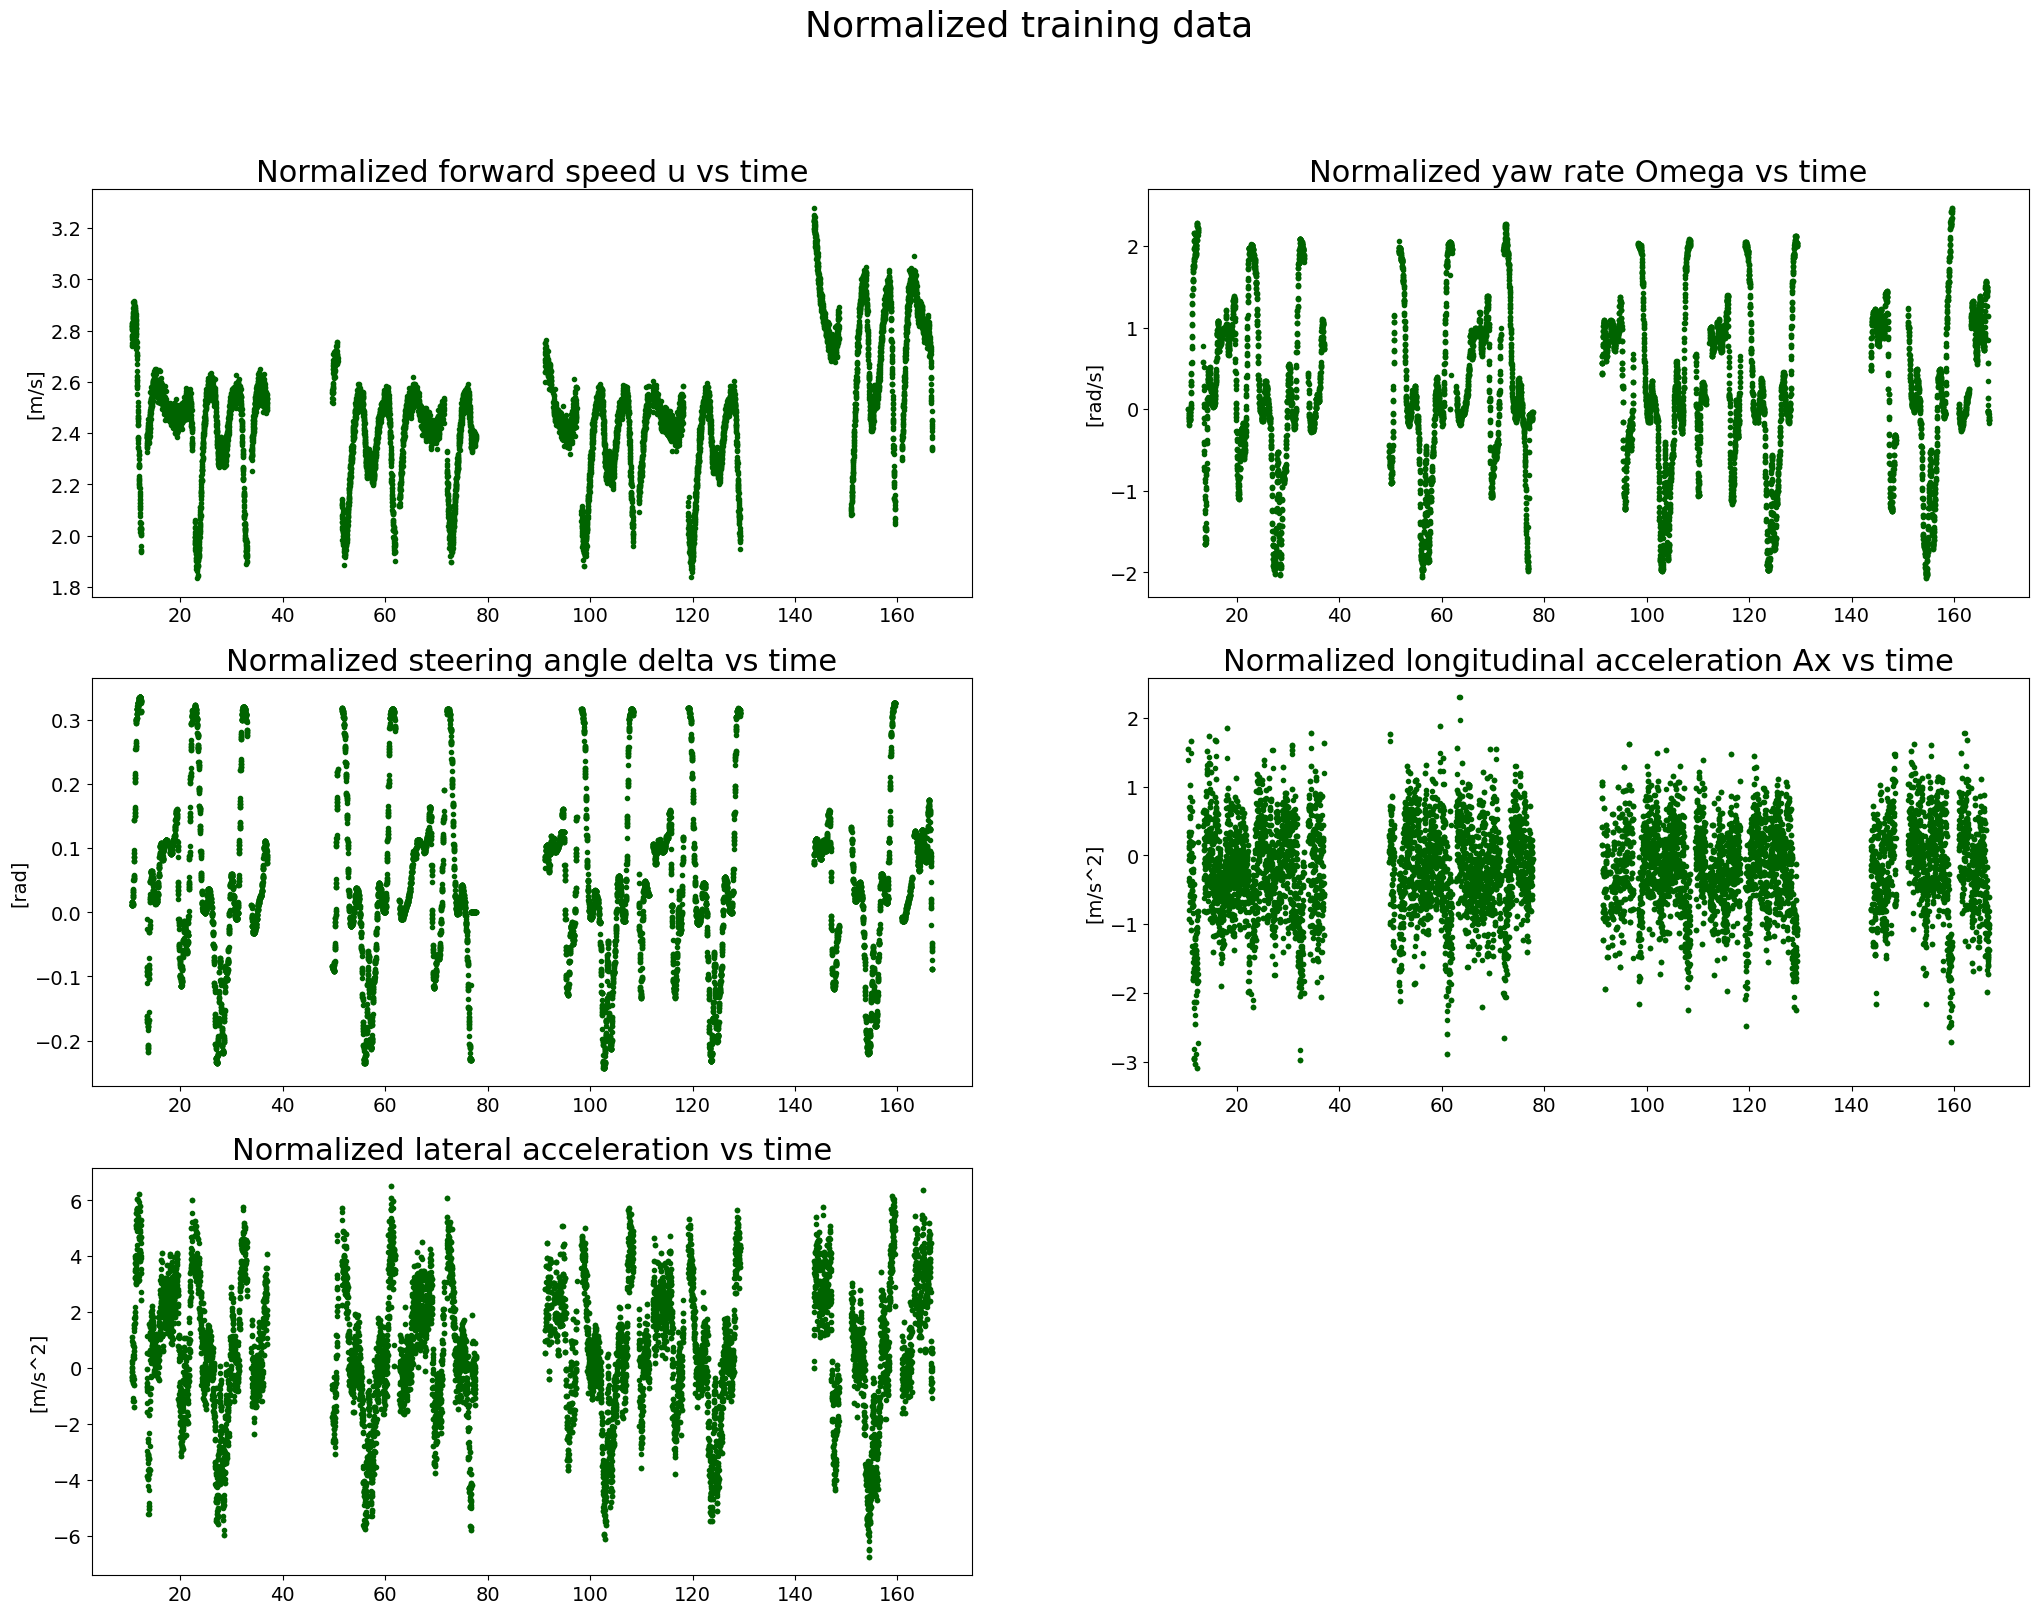

In [17]:
enable_plotTrainData = 1   # set this flag to 1 in order to plot normalized training data

if enable_plotTrainData==1:
  fig = plt.figure(figsize=(25,18))
  fig.suptitle('Normalized training data')
  ax1 = fig.add_subplot(321)
  ax2 = fig.add_subplot(322)
  ax3 = fig.add_subplot(323)
  ax4 = fig.add_subplot(324)
  ax5 = fig.add_subplot(325)
  ax1.plot(time_train, u_train_norm, '.', color='darkgreen')
  ax1.set(title="Normalized forward speed u vs time",  ylabel="[m/s]")
  ax2.plot(time_train, Omega_train_norm, '.', color='darkgreen')
  ax2.set(title="Normalized yaw rate Omega vs time", ylabel="[rad/s]")
  ax3.plot(time_train, delta_train_norm, '.', color='darkgreen')
  ax3.set(title="Normalized steering angle delta vs time", ylabel="[rad]")
  ax4.plot(time_train, Ax_train_norm, '.', color='darkgreen')
  ax4.set(title="Normalized longitudinal acceleration Ax vs time", ylabel="[m/s^2]")
  ax5.plot(time_train, Ay_train_norm, '.', color='darkgreen')
  ax5.set(title="Normalized lateral acceleration vs time", ylabel="[m/s^2]")
  #plt.grid(True)

  plt.show()

# Plot the normalized validation data

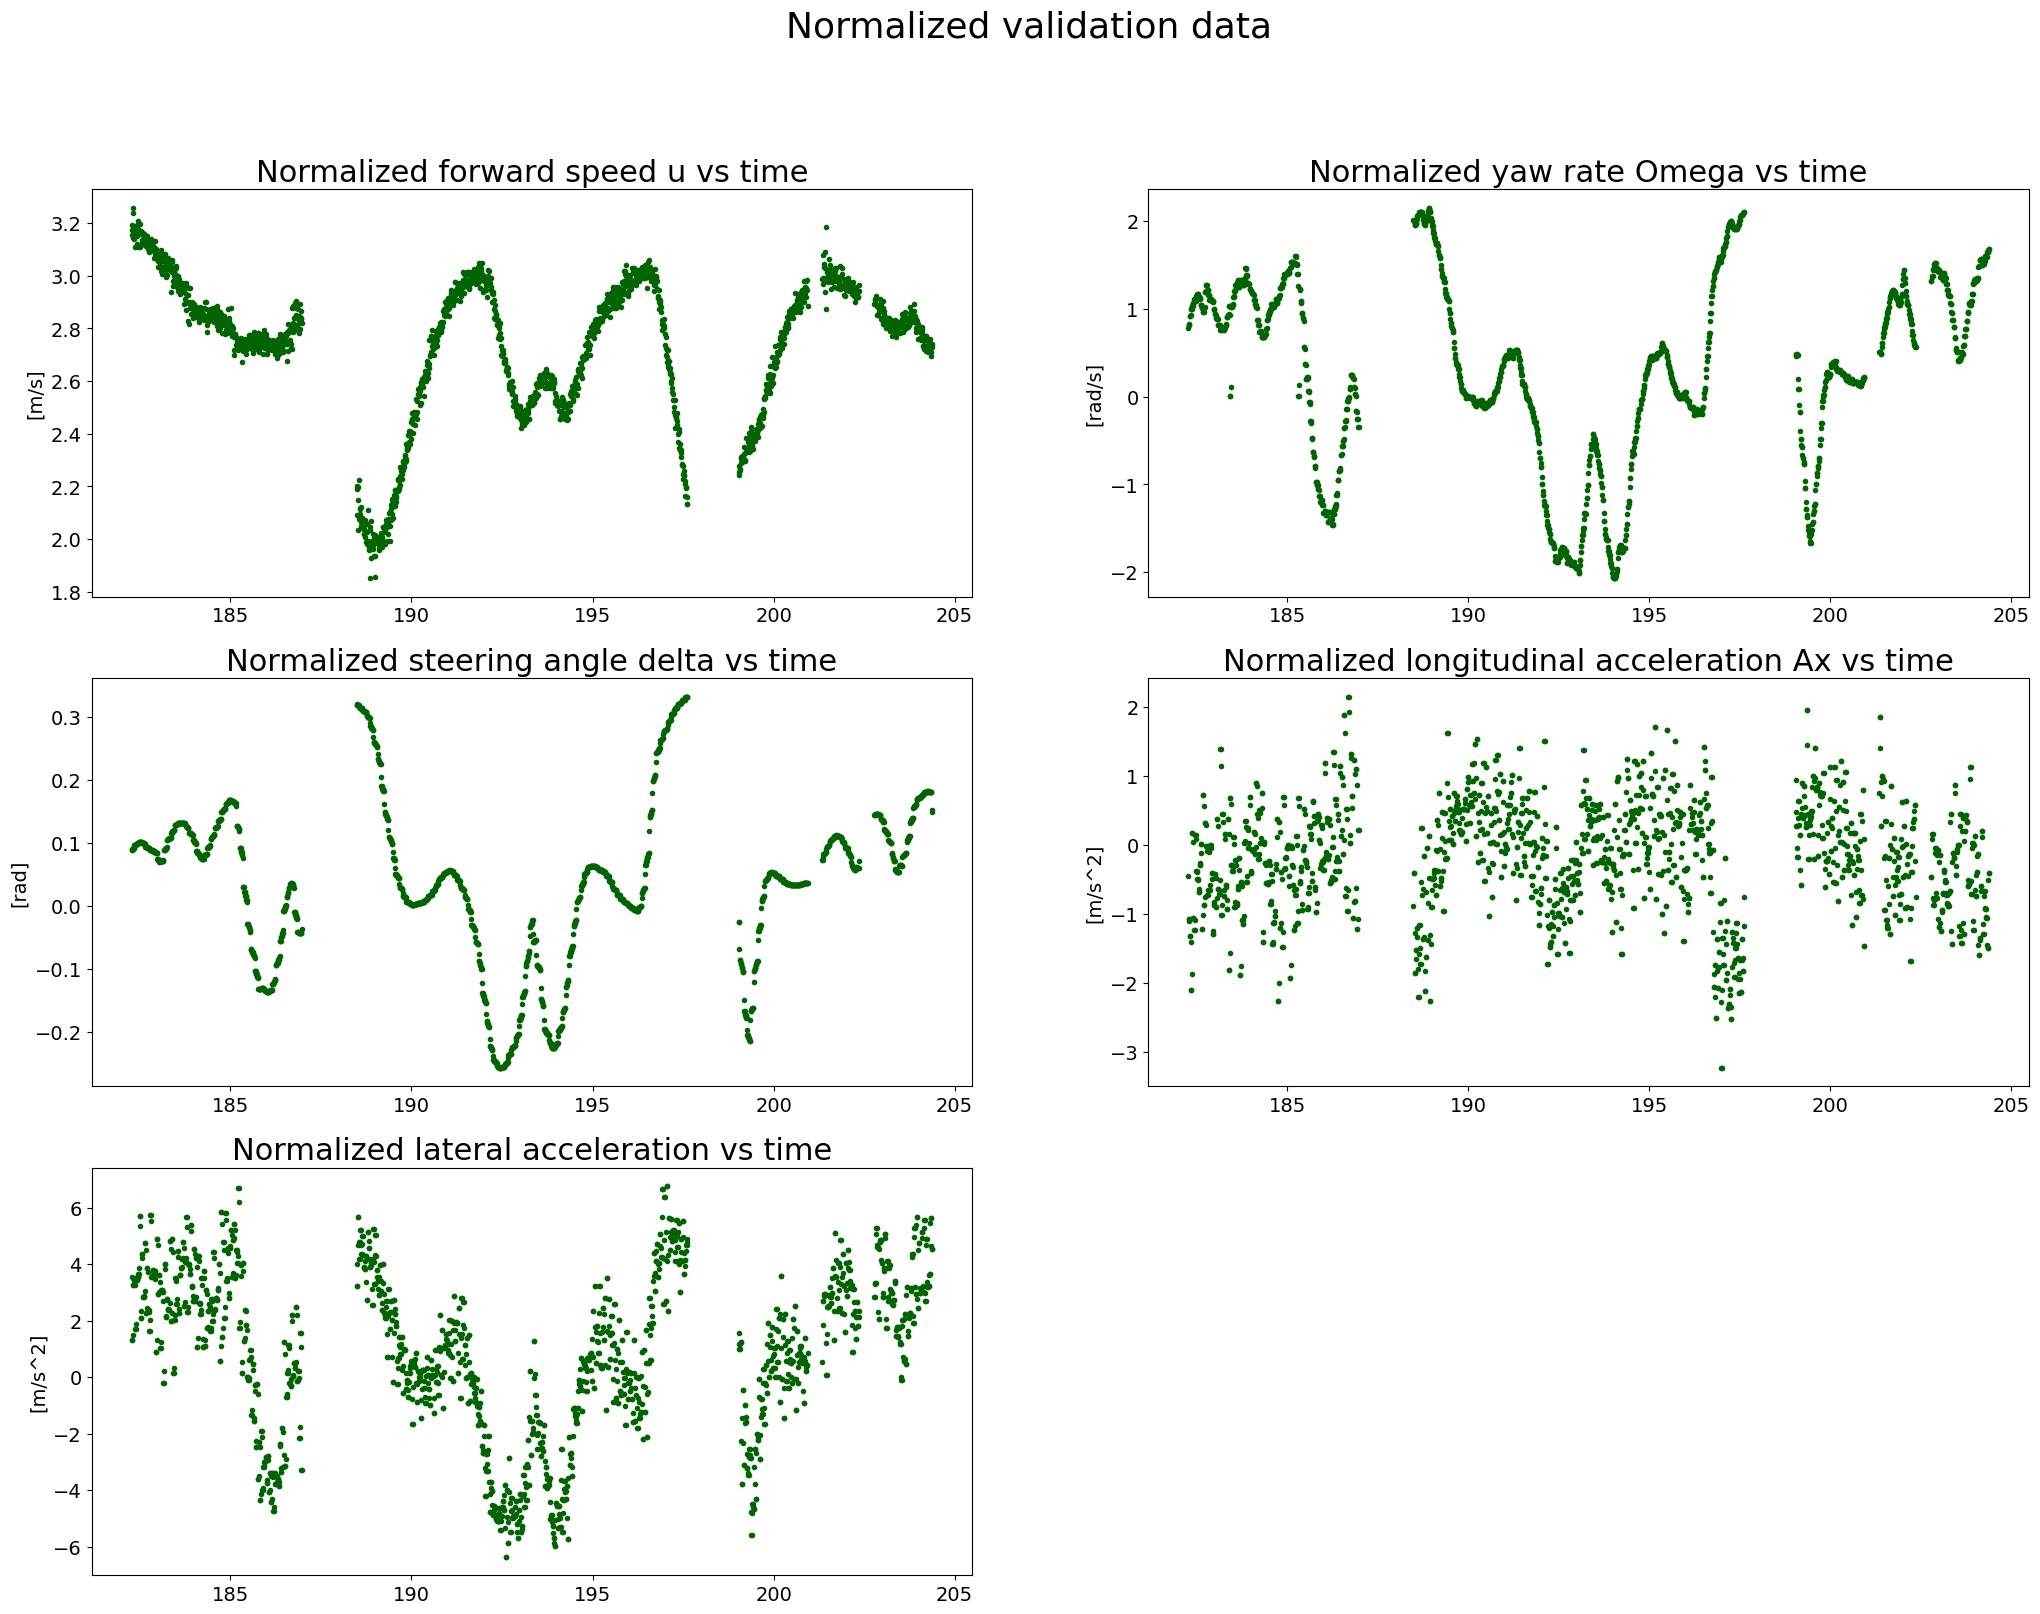

In [ ]:
enable_plotValidDta = 1   # set this flag to 1 in order to plot normalized validation data

if enable_plotValidDta==1:
  fig = plt.figure(figsize=(25,18))
  fig.suptitle('Normalized validation data')
  ax1 = fig.add_subplot(321)
  ax2 = fig.add_subplot(322)
  ax3 = fig.add_subplot(323)
  ax4 = fig.add_subplot(324)
  ax5 = fig.add_subplot(325)
  ax1.plot(time_valid, u_valid_norm, '.', color='darkgreen')
  ax1.set(title="Normalized forward speed u vs time",  ylabel="[m/s]")
  ax2.plot(time_valid, Omega_valid_norm, '.', color='darkgreen')
  ax2.set(title="Normalized yaw rate Omega vs time", ylabel="[rad/s]")
  ax3.plot(time_valid, delta_valid_norm, '.', color='darkgreen')
  ax3.set(title="Normalized steering angle delta vs time", ylabel="[rad]")
  ax4.plot(time_valid, Ax_valid_norm, '.', color='darkgreen')
  ax4.set(title="Normalized longitudinal acceleration Ax vs time", ylabel="[m/s^2]")
  ax5.plot(time_valid, Ay_valid_norm, '.', color='darkgreen')
  ax5.set(title="Normalized lateral acceleration vs time", ylabel="[m/s^2]")
  #plt.grid(True)

  plt.show()

# Structure of the Neural Network

## Define an RNN Cell, as a layer subclass

In [ ]:
class MyRNNCell(keras.layers.Layer):

  def __init__(self, units, autoRegr_window, RNN_kernel_init, **kwargs):
    self.units = units
    self.state_size = 1
    self.autoRegr_win = autoRegr_window
    self.RNN_kernel_init = RNN_kernel_init
    super(MyRNNCell, self).__init__(**kwargs)

  def build(self, input_shape):
    self.past_state_win = tf.Variable(initial_value=np.zeros((self.units,self.autoRegr_win)), trainable=False, dtype='float32')    
    self.recurrent_kernel = self.add_weight(
        shape=(self.autoRegr_win,self.units),
        initializer=self.RNN_kernel_init,   #tf.keras.initializers.Zeros()   tf.keras.initializers.GlorotNormal(seed=None)
        name='recurrent_kernel',trainable=True)
    self.built = True

  def call(self, input_at_t, states_at_t):
    self.past_state_win.assign(tf.concat([self.past_state_win[:,1:self.autoRegr_win],states_at_t[0]],1))
    state_at_t_plus_1 = K.dot(self.past_state_win,self.recurrent_kernel) + input_at_t
    output_at_t  = state_at_t_plus_1
    #print(states_at_t[0].shape)
    #print(self.past_state_win.shape)
    #print(self.past_state_win[:,0:self.autoRegr_win-1].shape)
    #print(prev_states.shape)
    #print(output_at_t.shape)
    #print(self.recurrent_kernel.shape)
    #print(self.kernel.shape)
    #print(input_at_t.shape)
    #print(state_at_t_plus_1.shape)
    #print("\n")
    return output_at_t, [output_at_t]

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'units': self.units,
        'state_size': self.state_size,
        'autoRegr_win': self.autoRegr_win
    })
    return config            

## Custom initializers

In [ ]:
# Use custom initializers
class MyInitializer(tf.keras.initializers.Initializer):

  def __init__(self, init_value):
    self.init_value = init_value

  def __call__(self, shape, dtype=None):
    return tf.convert_to_tensor(self.init_value)

  def get_config(self):  # To support serialization
    return {'init_value': self.init_value}

## Custom layers to perform operations with the inputs

In [ ]:
L = 0.325

class US_gradient(layers.Layer):
  def __init__(self, Kus_init, **kwargs):
    self.Kus_initial = Kus_init
    super().__init__(**kwargs)

  def build(self,input_shapes):
    self.Kus = self.add_weight(initializer=self.Kus_initial,name='Kus',trainable=True)  #tf.keras.initializers.Zeros()   shape=(1,1),
    self.built = True  

  def call(self, inputs):
    vx, ay = inputs
    output = ay*((L/(vx**2)) + self.Kus)
    return output

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'Kus_initial': self.Kus_initial
    })
    return config            

## NN parameters

In [ ]:
num_states_RNN = 1         # n° of 'hidden' states for the custom RNN
length_pastWindow = 30     # length of the past input (steering angle) window which is recursively fed back to the RNN
num_future_states = 2      # n° of states whose future evolution is fed to the RNN
num_samples_futureWindow = 30   # n° of samples in each of the windows (whose number is num_future_states) of 'future' values
numNeurons_FCLay_1 = 1
num_outputs_NN = 1

num_timesteps_window = None  #100  # n° of consecutive timesteps in a sequence (aka window) for which the RNN state must not be reset
batchSize = 1

## Initializers

In [ ]:
# initializers
Kus_guess = 0.0
Kus_init  = MyInitializer(Kus_guess)  

FC1_weights_init = tf.keras.initializers.Zeros()  #MyInitializer(FC1_weights_openLoop)   tf.keras.initializers.GlorotNormal(seed=None)
RNN_kernel_init = tf.keras.initializers.Zeros()   #MyInitializer(FC2_weights_openLoop)    

#RNN_kernel_guess = np.empty((length_pastWindow,num_states_RNN), dtype='float32')
#for ii in range(length_pastWindow):
#  RNN_kernel_guess[ii] = 0.01  
#RNN_kernel_init  = MyInitializer(RNN_kernel_guess)

## Define the NN model

Model: "NN_invSteer_struct_closedLoop_linear_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_vx (InputLayer)           [(1, None, 30)]      0                                            
__________________________________________________________________________________________________
input_ay (InputLayer)           [(1, None, 30)]      0                                            
__________________________________________________________________________________________________
threading (US_gradient)         (1, None, 30)        1           input_vx[0][0]                   
                                                                 input_ay[0][0]                   
__________________________________________________________________________________________________
FC1 (Dense)                     (1, None, 1)         30      

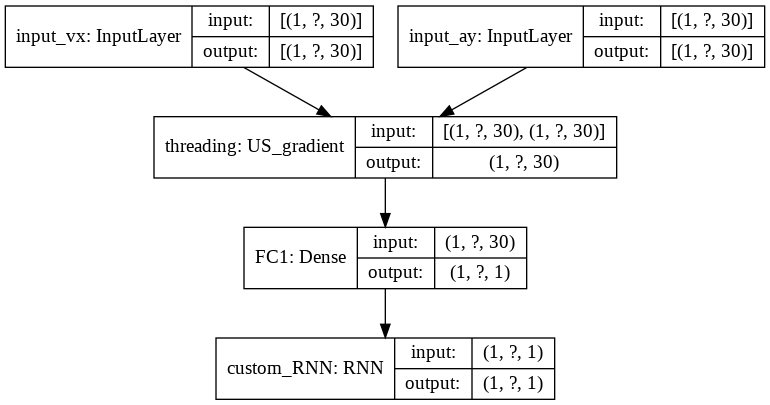

In [ ]:
# Create the NN model
def create_model():
  input_vx = Input(shape=(num_timesteps_window,num_samples_futureWindow),batch_size=batchSize,name="input_vx")
  input_ay = Input(shape=(num_timesteps_window,num_samples_futureWindow),batch_size=batchSize,name="input_ay")
  threaded_inputs = US_gradient(Kus_init,name="threading")([input_vx,input_ay])
  FC_1 = Dense(numNeurons_FCLay_1, kernel_initializer=FC1_weights_init, use_bias=False, name="FC1")   
  out_1 = FC_1(threaded_inputs)
  # Use the RNN cell in an RNN layer
  RNN_cell   = MyRNNCell(num_states_RNN, length_pastWindow, RNN_kernel_init)
  myLayerRNN = RNN(RNN_cell, return_sequences=True, return_state=False, stateful=False, name='custom_RNN')
  output = myLayerRNN(out_1)

  model = Model([input_vx,input_ay],output, name=NN_name)
  # optimizer parameters
  optimizer_pars = keras.optimizers.Nadam(learning_rate=0.001,epsilon=1e-07)  #tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
  # compile the model
  model.compile(loss='mean_squared_error', optimizer=optimizer_pars)  
  return model

if (use_TPU==1):
  with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
    model = create_model()
else:
  model = create_model()

model.summary()

plot_model(model, to_file='m.png', show_shapes=True, show_layer_names=True)

# Create the sequences of I/O traning and validation data 

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/' + ID + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
class DataGenerator(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, vx_in, ay_in, delta_out, batch_size, dim, length_futWindow, num_batches_per_epoch, shuffle=False):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.length_futWindow = length_futWindow
    self.num_batches_per_epoch = num_batches_per_epoch
    self.vx_in = vx_in
    self.ay_in = ay_in
    self.delta_out = delta_out
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    'Denotes the number of batches per epoch'
    return num_batches_per_epoch

  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]
    # Generate data
    X, y = self.__data_generation(list_IDs_temp)
    return X, y

  def on_epoch_end(self):
    'Updates indexes after each epoch'
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    'Generates data containing batch_size samples'  # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)
    # Generate data
    for i, ID in enumerate(list_IDs_temp):
      # Store sample
      X[i,] = np.load('data/' + ID + '.npy')
      # Store class
      y[i] = self.labels[ID]
    return ({"input_vx": v_x, "input_ay": a_y}, delta)

In [ ]:
# Parameters
params = {'dim': (32,32,32),
          'batch_size': 64,
          'n_classes': 6,
          'n_channels': 1,
          'shuffle': True}

# Datasets
partition = # IDs
labels = # Labels

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

# Design model
model = Sequential()
[...] # Architecture
model.compile()

# Train model on dataset
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6)

In [ ]:
# ----------------------------
# NN training data 
# ----------------------------
numSamples_train = u_train_norm.shape[0]
numWindows_train = math.floor(numSamples_train/num_timesteps_window)-1  # the n° of independent sequences (aka windows) in a batch is numWindows_train*batchSize
NN_inputs_vx_train = np.zeros((numWindows_train,num_timesteps_window,num_samples_futureWindow))  # initialize 
NN_inputs_ay_train = np.zeros((numWindows_train,num_timesteps_window,num_samples_futureWindow))  # initialize 
NN_output_train = np.zeros((numWindows_train,num_timesteps_window,num_outputs_NN))               # initialize

delta_IC_train = np.array([delta_train_norm[0]]*length_pastWindow).transpose()
delta_train_norm_IC = np.concatenate((delta_IC_train.flatten(),delta_train_norm.flatten()),axis=0)
for ii in range(0,numWindows_train):
  for jj in range(0,num_timesteps_window):  
    input_window_vx = u_train_norm[ii*num_timesteps_window+jj:ii*num_timesteps_window+jj+num_samples_futureWindow,].flatten().tolist()   
    input_window_ay = Ay_train_norm[ii*num_timesteps_window+jj:ii*num_timesteps_window+jj+num_samples_futureWindow,].flatten().tolist()   
    output_window = delta_train_norm_IC[ii*num_timesteps_window+jj+length_pastWindow,].flatten().tolist()            
    NN_inputs_vx_train[ii,jj,:] = input_window_vx         
    NN_inputs_ay_train[ii,jj,:] = input_window_ay      
    NN_output_train[ii,jj,:] = output_window  

NN_inputs_train = [NN_inputs_vx_train, NN_inputs_ay_train]

# ----------------------------
# NN validation data
# ----------------------------
numSamples_valid = u_valid_norm.shape[0]
numWindows_valid = math.floor(numSamples_valid/num_timesteps_window)-1  # the n° of independent sequences (aka windows) in a batch is numWindows_valid*batchSize
NN_inputs_vx_valid = np.zeros((numWindows_valid,num_timesteps_window,num_samples_futureWindow))  # initialize 
NN_inputs_ay_valid = np.zeros((numWindows_valid,num_timesteps_window,num_samples_futureWindow))  # initialize 
NN_output_valid = np.zeros((numWindows_valid,num_timesteps_window,num_outputs_NN))       # initialize

delta_IC_valid = np.array([delta_valid_norm[0]]*length_pastWindow).transpose()
delta_valid_norm_IC = np.concatenate((delta_IC_valid.flatten(),delta_valid_norm.flatten()),axis=0)
for ii in range(0,numWindows_valid):
  for jj in range(0,num_timesteps_window):  
    input_window_vx = u_valid_norm[ii*num_timesteps_window+jj:ii*num_timesteps_window+jj+num_samples_futureWindow,].flatten().tolist()   
    input_window_ay = Ay_valid_norm[ii*num_timesteps_window+jj:ii*num_timesteps_window+jj+num_samples_futureWindow,].flatten().tolist()    
    output_window = delta_valid_norm_IC[ii*num_timesteps_window+jj+length_pastWindow,].flatten().tolist()            
    NN_inputs_vx_valid[ii,jj,:] = input_window_vx         
    NN_inputs_ay_valid[ii,jj,:] = input_window_ay        
    NN_output_valid[ii,jj,:] = output_window   

NN_inputs_valid = [NN_inputs_vx_valid, NN_inputs_ay_valid]

validatData     = (NN_inputs_valid,NN_output_valid)
validationFreq  = 1  # validation frequency

In [ ]:
print(NN_inputs_vx_valid[1,99,:])
print(NN_inputs_vx_valid[2,0,:])
print("\n")
print(NN_output_train[0,0,:])
print(NN_output_train[0,1,:])

[9.30301135 9.30302246 9.30303347 9.3030444  9.30305529 9.30306615
 9.303077   9.30308786 9.30309876 9.30310972 9.30312075 9.30313188
 9.30314313 9.30315451 9.30316604 9.30317775 9.30318965 9.30320173
 9.30321397 9.3032265  9.30323936 9.3032525  9.30326591 9.30327959
 9.30329357 9.30330788 9.30332252 9.3033375  9.30335282 9.3033685 ]
[9.30302246 9.30303347 9.3030444  9.30305529 9.30306615 9.303077
 9.30308786 9.30309876 9.30310972 9.30312075 9.30313188 9.30314313
 9.30315451 9.30316604 9.30317775 9.30318965 9.30320173 9.30321397
 9.3032265  9.30323936 9.3032525  9.30326591 9.30327959 9.30329357
 9.30330788 9.30332252 9.3033375  9.30335282 9.3033685  9.30338454]


[0.]
[0.00029653]


# Train the Neural Network

In [ ]:
# --------------------------------
# flag to be set to 1 in order to train now the NN, 
# or to 0 to load saved training results
# --------------------------------
flag_trainNow = 1

# set this flag to 1 in order to continue the training of a model
flag_continueTraining = 0

# NN hyperparameters
numEpochs = 8

if (flag_continueTraining==1 or (flag_continueTraining==0 and flag_trainNow==0)):
  model = tf.keras.models.load_model(NN_dataPath + 'trained_network/' + NN_name + '.h5')  

if (flag_trainNow==1 or flag_continueTraining==1):
  start_time = time.time()  # start counting time
  #netT = model.fit(NN_inputs_train, NN_output_train, epochs=numEpochs, batch_size=batchSize, verbose=1, shuffle=False, validation_data=validatData, 
  #                   validation_freq=validationFreq, validation_batch_size=batchSize, use_multiprocessing=True)  
  for i in range(numEpochs): 
    model.reset_states()
    netT = model.fit(NN_inputs_train, NN_output_train, epochs=1, batch_size=batchSize, verbose=1, shuffle=False, validation_data=validatData, 
                     validation_freq=validationFreq, validation_batch_size=batchSize, use_multiprocessing=True)  
  stop_time = time.time()
  print("The training took {:3.1f} min".format((stop_time-start_time)/60)) 

653/653 [==============================] - 5s 8ms/step - loss: 4.3518e-07 - val_loss: 4.3201e-06
The training took 0.7 min


# Post-processing with the trained net

## Training curves

In [ ]:
if (flag_trainNow==1 or flag_continueTraining==1):
  # Plot training & validation loss values
  fig = plt.figure(figsize=(25,13))
  fig.suptitle('Model loss')
  ax1 = fig.add_subplot(111)
  plt.grid(True)
  ax1.plot(netT.history['loss'])
  ax1.plot(netT.history['val_loss'])
  ax1.set(xlabel="Epoch", ylabel="Loss")
  ax1.legend(['Train', 'Validation'], loc='upper left')
  ax1.set_yscale('log')

  plt.show()

## Prediction using training and validation data



In [ ]:
num_training_samples = numWindows_train*num_timesteps_window
num_validat_samples  = numWindows_valid*num_timesteps_window
time_train_NN  = time_train[0:num_training_samples,0]
time_valid_NN  = time_valid[0:num_validat_samples,0]

model.reset_states()
delta_NN_train_full = model.predict(NN_inputs_train, batch_size=batchSize, verbose=1, use_multiprocessing=True)  
model.reset_states()
delta_NN_valid_full = model.predict(NN_inputs_valid, batch_size=batchSize, verbose=1, use_multiprocessing=True)  

delta_NN_train = np.zeros(len(time_train_NN))  # initialize
kk = 0
for ii in range(0,numWindows_train):
  for jj in range(0,num_timesteps_window):  
    delta_NN_train[kk] = delta_NN_train_full[ii,jj,-1]
    kk += 1

delta_NN_valid = np.zeros(len(time_valid_NN))  # initialize
kk = 0
for ii in range(0,numWindows_valid):
  for jj in range(0,num_timesteps_window):  
    delta_NN_valid[kk] = delta_NN_valid_full[ii,jj,-1]
    kk += 1

33/33 [==============================] - 0s 3ms/step


In [ ]:
fig = plt.figure(figsize=(25,13))
fig.suptitle('Prediction using the NN')
ax1 = fig.add_subplot(211)
plt.grid(True)
ax2 = fig.add_subplot(212)
plt.grid(True)
ax1.plot(time_train, np.rad2deg(delta_train), color='darkgreen', linewidth=3)
ax1.plot(time_train_NN, np.rad2deg(delta_NN_train*max_delta), color='orange', linewidth=1)
ax1.set(title="Steering angle vs time, training data",  ylabel="[deg]")
ax1.legend(['real', 'NN output'], loc='upper left')
#ax1.set_xlim([25200,25250])
ax2.plot(time_valid, np.rad2deg(delta_valid), color='darkgreen', linewidth=3)
ax2.plot(time_valid_NN, np.rad2deg(delta_NN_valid*max_delta), color='orange', linewidth=1)
ax2.set(title="Steering angle vs time, validation data", ylabel="[deg]")
ax2.legend(['real', 'NN output'], loc='upper left')
#ax2.set_xlim([-2,2])

plt.show()

In [ ]:
print(delta_NN_train_full[0,99,:])
print(delta_NN_train_full[1,0,:])

[0.03166907]
[0.03177352]


## Quality of the NN predictions

In [ ]:
delta_train_real = delta_train[0:len(delta_NN_train),0]
delta_train_pred = delta_NN_train*max_delta

delta_valid_real = delta_valid[0:len(delta_NN_valid),0]
delta_valid_pred = delta_NN_valid*max_delta

# ---------------------
# RMS error
# ---------------------
# training
ms_error_train_tmp = 0  # initialize
for ii in range(0,len(delta_train_real)): 
  ms_error_train_tmp += ((delta_train_real[ii]-delta_train_pred[ii])**2.0)
ms_error_train  = ms_error_train_tmp/len(delta_train_real)   #mean_squared_error(delta_train_real,delta_train_pred)
rms_error_train = math.sqrt(ms_error_train)
#validation
ms_error_valid_tmp = 0  # initialize
for ii in range(0,len(delta_valid_real)): 
  ms_error_valid_tmp += ((delta_valid_real[ii]-delta_valid_pred[ii])**2.0)
ms_error_valid  = ms_error_valid_tmp/len(delta_valid_real)   #mean_squared_error(delta_valid_real,delta_valid_pred)
rms_error_valid = math.sqrt(ms_error_valid)

# ---------------------
# Variance accounted for (VAF)
# ---------------------
VAF_train = explained_variance_score(delta_train_real,delta_train_pred)
VAF_valid = explained_variance_score(delta_valid_real,delta_valid_pred)

print("The mean square error in training is", ms_error_train, "rad")
print("The root mean square error in training is", rms_error_train, "rad")
print("The variance accounted for (VAF) in training is", VAF_train)
print("\n")
print("The mean square error in validation is", ms_error_valid, "rad")
print("The root mean square error in validation is", rms_error_valid, "rad")
print("The variance accounted for (VAF) in validation is", VAF_valid)

The mean square error in training is 4.804897732892702e-06 rad
The root mean square error in training is 0.002192007694533188 rad
The variance accounted for (VAF) in training is 0.9931169277898635


The mean square error in validation is 5.1606459153130845e-06 rad
The root mean square error in validation is 0.0022717055080518434 rad
The variance accounted for (VAF) in validation is 0.9907210113982006


## Extract NN weights and biases

In [ ]:
# --------------------------------
# Understeering gradient
# --------------------------------
Kus_weight = model.layers[2].get_weights()[0]
print("Kus_weight: ", np.array2string(Kus_weight))  #Kus_weight[0][0]

# --------------------------------
# Weights and biases for the first FC layer
# --------------------------------
FC1_layer_weights = model.layers[3].get_weights()[0]
#FC1_layer_biases  = model.layers[4].get_weights()[1]

# --------------------------------
# Weights and biases for the auto-regressive layer
# --------------------------------
autoReg_layer_weights = model.layers[4].get_weights()[0]
#autoReg_layer_biases  = model.layers[4].get_weights()[1]

print(Kus_weight.shape)
print(FC1_layer_weights.shape)
print(autoReg_layer_weights.shape)

Kus_weight:  0.0013206
()
(30, 1)
(30, 1)


## Save the trained network

In [ ]:
if (flag_trainNow==1 or flag_continueTraining==1):
  # Save the entire model to an HDF5 file
  model.save(NN_dataPath + 'trained_network/' + NN_name + '.h5') 

  model_layers = ["FC", "tanh", "FC", "FC"]
  scipy.io.savemat(NN_dataPath + 'trained_network/' + NN_name + '.mat', {'layers':                model_layers,
                                                                         'num_states_RNN':        num_states_RNN,
                                                                         'length_pastWindow':     length_pastWindow,
                                                                         'num_future_states':     num_future_states,
                                                                         'num_samples_futureWindow':  num_samples_futureWindow,
                                                                         'num_outputs_NN':        num_outputs_NN,
                                                                         'FC1_numUnits':          numNeurons_FCLay_1,
                                                                         'num_FC_layers':         1,
                                                                         'FC1_weights':           FC1_layer_weights,
                                                                         #'FC1_biases':           FC1_layer_biases,
                                                                         'autoReg_layer_weights': autoReg_layer_weights,
                                                                         'idx_firstSample_train': idx_first_train,
                                                                         'idx_firstSample_valid': idx_first_valid,
                                                                         'idx_lastSample_train':  idx_last_train,
                                                                         'idx_lastSample_valid':  idx_last_valid})

if (use_googleDrive==0):
  model.save('../content/sample_data/' + NN_name + '.h5') 

## Plot NN weights and biases

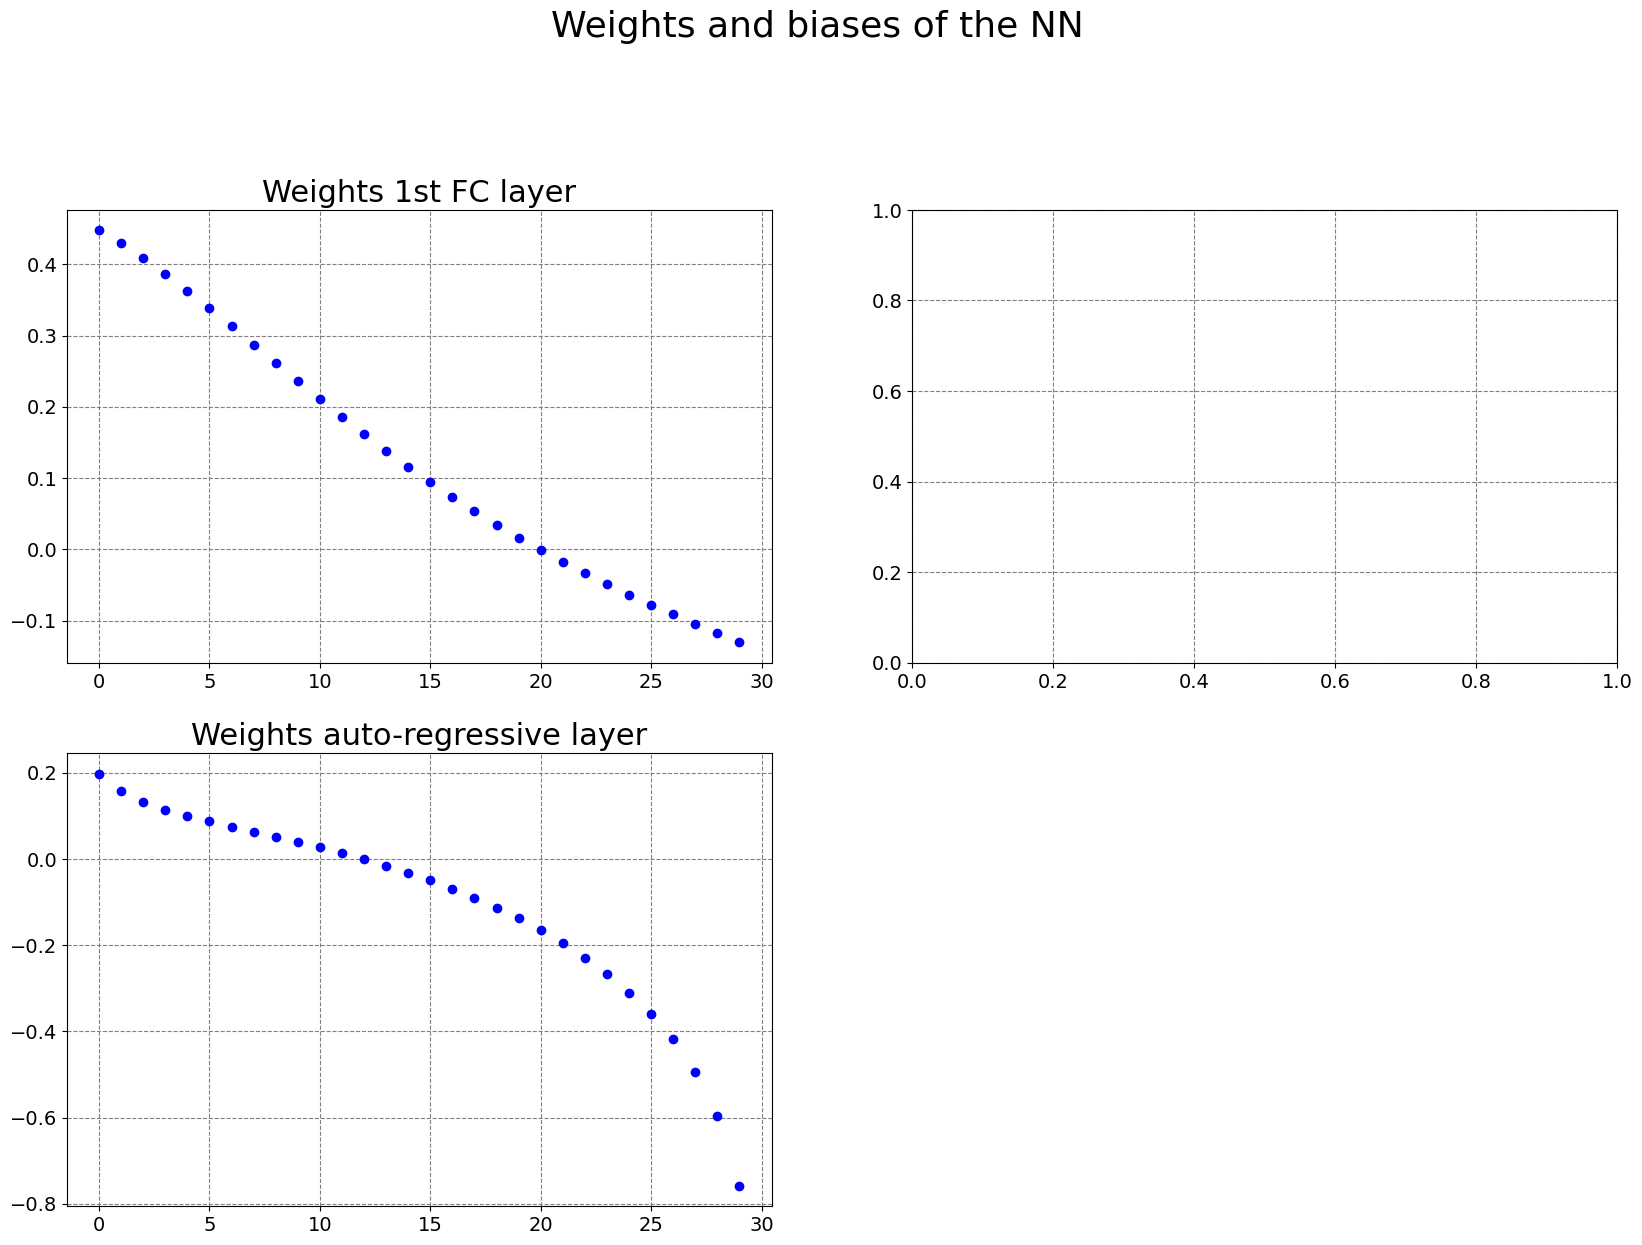

In [ ]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Weights and biases of the NN')
ax1 = fig.add_subplot(321)
plt.grid(True)
ax2 = fig.add_subplot(322)
plt.grid(True)
ax3 = fig.add_subplot(323)
plt.grid(True)

ax1.plot(FC1_layer_weights.flatten(), 'o',color='blue')
ax1.set(title="Weights 1st FC layer")
#ax2.plot(FC1_layer_biases.flatten(), 'o',color='blue')
#ax2.set(title="Biases 1st FC layer")

ax3.plot(autoReg_layer_weights.flatten(), 'o',color='blue')
ax3.set(title="Weights auto-regressive layer")

plt.show()